# Machine Learning Model v2
## COMPTNG 16B Project

We have added more interpretability features, primarily SHAP interpretation. <br>
All features from tf1.ipynb are imported into this file.

### Packages and Data Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn as sns

import pandas as pd

# set random seeds
seed_value= 1234
np.random.seed(seed_value)
tf.random.set_seed(seed_value) 

In [2]:
df = pd.read_csv("stats.csv")
df.astype({"xG": "float32", "possession": "float32", "passing_accuracy": "float32"})

target = df[["goals"]]
features = df[["possession", "passing_accuracy", "shots_on_target", "saves", "tackles", "fouls", 
               "interceptions", "goal_kicks", "corners", "crosses"]]

train_features, test_features, train_targets, test_targets = train_test_split(features, target, test_size = 0.2)
train_features, val_features, train_targets, val_targets = train_test_split(train_features, train_targets, test_size = 0.2)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [3]:
features

,possession,passing_accuracy,shots_on_target,saves,tackles,fouls,interceptions,goal_kicks,corners,crosses
0,0.57,0.79,7,5,24,10,11,6,11,15
1,0.48,0.82,6,3,21,16,25,4,4,19
2,0.52,0.76,2,2,21,16,4,11,14,11
3,0.55,0.79,4,4,19,24,6,8,8,10
4,0.42,0.67,3,2,14,6,9,6,7,10
...,...,...,...,...,...,...,...,...,...,...
755,0.65,0.79,2,2,17,13,8,5,2,15
756,0.54,0.69,3,1,11,14,6,11,7,9
757,0.57,0.88,8,3,26,15,5,5,1,8
758,0.50,0.80,3,3,17,11,13,8,2,9


### Model creation

In [4]:
model = models.Sequential([
    keras.Input(shape = (10, )), 
    layers.Dense(10, activation = "elu"),
    layers.Dense(60, activation = "selu"),
    layers.Dense(30, activation = "selu"), 
    layers.Dense(12, activation = "selu"), 
    layers.Dense(1)
])

# To have at least steps_per_epoch * epochs batches
batch = 50
steps = len(train_features)//batch
validation_steps = len(val_features)//batch

model.compile(optimizer = "adam",
              loss = "mse")

model.fit(train_features, 
                    train_targets, 
                    epochs = 200, 
                    batch_size = batch, 
                    verbose = 0, 
                    steps_per_epoch = steps, 
                    validation_data = (val_features, val_targets), 
                    validation_steps = validation_steps)


### Model evaluation

In [5]:
model.evaluate(test_features, test_targets, verbose = 0)

1.2714515924453735

### Model interpretability

We use partial dependence plots, along with individual conditional expectations.

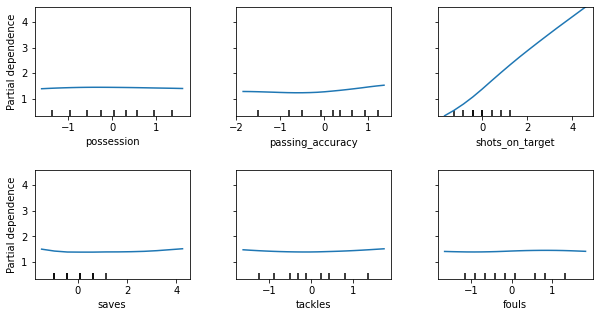

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence, plot_partial_dependence

# sklearn has a bug when utilizing non-sklearn models
# This is incorporated to fix it.
from sklearn.utils import validation

model._estimator_type = "regressor"
model.dummy_ = None   # works around the underscore issue
validation.check_is_fitted(estimator=model)

features_list = ["possession", "passing_accuracy", "shots_on_target", "saves", "tackles", "fouls"]

plot_partial_dependence(model, features = features_list, X = train_features,
                        feature_names = features_list, grid_resolution = 20)

fig = plt.gcf()
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.set_figheight(5)
fig.set_figwidth(10)

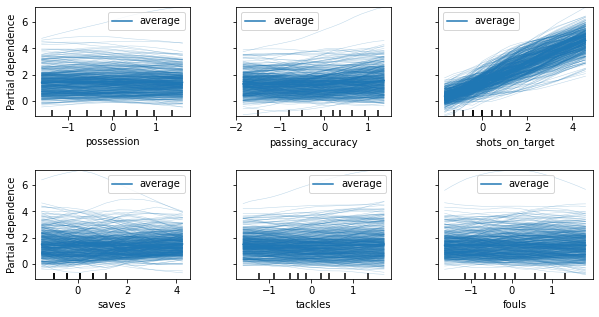

In [7]:
plot_partial_dependence(model, features = features_list, X = train_features, kind = "both", 
                        feature_names = features_list, grid_resolution = 20)

fig = plt.gcf()
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.set_figheight(5)
fig.set_figwidth(10)

New data begins from here.

### Inspection before SHAP

In [8]:
# Check the current error between prediction and current data
predictions = model.predict(test_features)
predictions - test_targets

,goals
157,-1.102187
360,-0.198557
524,0.547166
262,1.466817
697,-0.633951
...,...
277,0.790490
387,-0.908554
214,0.473337
467,-0.135390


### SHAP interpretability

In [9]:
import shap

In [10]:
# Enables the display of SHAP plots
shap.initjs()

In [11]:
# Takes the trained Keras model and explains why it makes different predictions for different matches
# Here, we use a selection of the first 100 samples from the entire dataset to represent "typical" feature values
explainer = shap.KernelExplainer(model.predict, features)

Using 760 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Explaining a single prediction.

In [12]:
# Computes the corresponding SHAP values
# Here we use 200 perterbation samples to estimate the SHAP values for a given prediction
shap_values = explainer.shap_values(features.iloc[0,:], nsamples=200)

In [13]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'shape of the set: {shap_values[0].shape}')

length of SHAP values: 1
shape of the set: (10,)


In [14]:
shap.force_plot(explainer.expected_value, shap_values[0], features.iloc[0,:])

Explaining many predictions.

In [15]:
shap_values100 = explainer.shap_values(features.iloc[100:200,:], nsamples=200)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [16]:
shap_values100

NameError: name 'shap_values100' is not defined

In [17]:
shap.force_plot(explainer.expected_value, shap_values100[0], features.iloc[100:200,:])

NameError: name 'shap_values100' is not defined

We can create a function that takes in a sample index from 0 to 100. <br>
This function then uses 200 perterbation samples to estimate the SHAP values for the prediction of the value corresponding to the index.

In [18]:
def shap_predictone(index=0):
    if index < 0 or index >= 100:
        print("Index must be between 0 and 99, inclusive")
        return False
    
    explainer = shap.KernelExplainer(model.predict, features.iloc[:100,:])
    shap_values = explainer.shap_values(features.iloc[index,:], nsamples=200)
    return shap.force_plot(explainer.expected_value, shap_values[0], features.iloc[index,:])

In [19]:
shap_predictone(10)

Exception ignored in: <function tqdm.__del__ at 0x000001DA4B86A040>
Traceback (most recent call last):
  File "C:\Users\zackr\anaconda3\envs\pic16b\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\zackr\anaconda3\envs\pic16b\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
